# Init

In [1]:
import hnswlib
import numpy as np
import sqlite3
import pickle
#import tqdm
from tqdm.notebook import tqdm, trange
import time

In [2]:
# Open the database
if 'conn' not in locals():
  conn = sqlite3.connect('../steam_instructor-xl.db')

In [3]:
# Helper functions

def get_any_description_embedding():
    c = conn.cursor()

    c.execute(f'''
        SELECT embedding FROM description_embeddings LIMIT 1
    ''')
    results = c.fetchone()[0]

    c.close()

    return pickle.loads(results)

def get_description_embeddings_for_appid(appid):
    c = conn.cursor()

    c.execute(f'''
        SELECT embedding FROM description_embeddings WHERE appid = ?
    ''', (appid,))
    #results = c.fetchone()[0]
    results = c.fetchall()

    c.close()

    if len(results) == 0:
        return []
    #    raise ValueError(f'No description embedding found for appid {appid}')
    #print(type(results))

    #return pickle.loads(results[0][0])
    
    embedding, = results[0]
    return pickle.loads(embedding)

    #return [pickle.loads(embedding) for embedding, in results]

def get_review_embeddings_for_appid(appid):
    c = conn.cursor()

    c.execute(f'''
        SELECT recommendationid, embedding
        FROM review_embeddings
        WHERE appid = ?
    ''', (appid,))
    results = c.fetchall()

    c.close()

    #if len(results) == 0:
    #    raise ValueError(f'No review embeddings found for appid {appid}')

    return {recommendationid: pickle.loads(embedding) for recommendationid, embedding in results}

def get_count_appids_with_description_embeddings():
    c = conn.cursor()

    c.execute(f'''
        SELECT COUNT(DISTINCT appid) FROM description_embeddings
    ''')
    results = c.fetchone()[0]

    c.close()

    return results

def get_count_appids_with_description_and_review_embeddings():
    c = conn.cursor()

    c.execute(f'''
        SELECT COUNT(DISTINCT appid) FROM description_embeddings
        WHERE appid IN (
            SELECT DISTINCT appid FROM review_embeddings
        )
    ''')
    results = c.fetchone()[0]

    c.close()

    return results

def get_count_appids_with_description_or_review_embeddings():
    c = conn.cursor()

    c.execute(f'''
        SELECT COUNT(DISTINCT appid) FROM (
            SELECT appid FROM description_embeddings
            UNION
            SELECT appid FROM review_embeddings
        )
    ''')
    results = c.fetchone()[0]

    c.close()

    return results

def get_count_appids_with_review_embeddings():
    c = conn.cursor()

    c.execute(f'''
        SELECT COUNT(DISTINCT appid) FROM review_embeddings
    ''')
    results = c.fetchone()[0]

    c.close()

    return results

def get_all_description_embeddings_generator(page_size):
    c = conn.cursor()

    c.execute(f'''
        SELECT appid, embedding FROM description_embeddings
    ''')

    while True:
        results = c.fetchmany(page_size)
        if not results:
            break
        for appid, embedding in results:
            yield appid, pickle.loads(embedding)

    c.close()

def get_batched_description_embeddings_generator(page_size):
    c = conn.cursor()

    c.execute(f'''
        SELECT appid, embedding FROM description_embeddings
    ''')

    while True:
        results = c.fetchmany(page_size)
        if not results:
            break
        yield [(appid, pickle.loads(embedding)) for appid, embedding in results]

    c.close()

def get_all_review_embeddings_generator(page_size):
    c = conn.cursor()

    c.execute(f'''
        SELECT appid, embedding FROM review_embeddings
    ''')

    while True:
        results = c.fetchmany(page_size)
        if not results:
            break
        for appid, embedding in results:
            yield appid, pickle.loads(embedding)

    c.close()

def get_appids_with_reviews():
    c = conn.cursor()

    c.execute(f'''
        SELECT DISTINCT appid FROM review_embeddings
    ''')

    results = c.fetchall()

    c.close()

    return [appid for appid, in results]

def get_appids_with_descriptions():
    c = conn.cursor()

    c.execute(f'''
        SELECT DISTINCT appid FROM description_embeddings
    ''')
    results = c.fetchall()

    c.close()

    return [appid for appid, in results]

def mean_pooling(embeddings):
    return np.sum(embeddings, axis=0) / len(embeddings)

def pool_description_embeddings(embeddings):
  # embeddings[chunk_size][embedding_dim]
  return mean_pooling(embeddings)

def pool_review_embeddings(embeddings):
  # embeddings[review_id][chunk_size][embedding_dim]
  flat_embeddings = [review_embedding for review_id in embeddings for review_embedding in embeddings[review_id]]
  # flat_embeddings[chunk_size][embedding_dim]
  return mean_pooling(flat_embeddings)

def get_pooled_description_embedding_for_appid(appid):
    return mean_pooling(get_description_embeddings_for_appid(appid))

def get_pooled_review_embeddings_for_appid(appid):
    all_review_embeddings = get_review_embeddings_for_appid(appid)
    flat_review_embeddings = [review_embedding for review_id in all_review_embeddings for review_embedding in all_review_embeddings[review_id]]
    return mean_pooling(flat_review_embeddings)

def get_reviews_by_appid_batched(page_size=1000):
    appids = get_appids_with_reviews()

    for i in range(0, len(appids), page_size):
        yield [(appid, get_pooled_review_embeddings_for_appid(appid)) for appid in appids[i:i+page_size]]

def get_mixed_by_appid_batched(page_size = 1000, review_weight = 0.5):
  appids_with_description_embeddings = set(get_appids_with_descriptions())
  appids_with_reviews = set(get_appids_with_reviews())
  appids = list(appids_with_description_embeddings.union(appids_with_reviews))
  #appids = list(appids_with_description_embeddings.intersection(appids_with_reviews))


  for i in range(0, len(appids), page_size):
    page = []
    for appid in appids[i:i+page_size]:
      all_description_embeddings = get_description_embeddings_for_appid(appid)
      all_review_embeddings = get_review_embeddings_for_appid(appid)

      if len(all_review_embeddings) == 0 and len(all_description_embeddings) == 0:
        raise ValueError(f"No description or review embeddings found for appid {appid}")
      
      if len(all_review_embeddings) == 0:
        #review_weight = 0.0
        description_embedding = pool_description_embeddings(all_description_embeddings)
        page.append((appid, description_embedding))
      elif len(all_description_embeddings) == 0:
        #review_weight = 1.0
        review_embedding = pool_review_embeddings(all_review_embeddings)
        page.append((appid, review_embedding))
      else:
        # Weighted average of description and review embeddings
        description_embedding = pool_description_embeddings(all_description_embeddings)
        review_embedding = pool_review_embeddings(all_review_embeddings)
        final_embedding = review_weight * review_embedding + (1.0 - review_weight) * description_embedding

        '''
        if description_embedding.shape != review_embedding.shape:
          print(f"All description embeddings length: {len(all_description_embeddings)}")
          for desc in all_description_embeddings:
            #print(f"Description embedding shape: {desc.shape}")
            print(f"Element[] length: {len(desc)}")
            print(f"Element[][] length: {len(desc[0])}")
          print(f"Description embedding shape: {description_embedding.shape}, Review embedding shape: {review_embedding.shape}")
          print("")
        '''

        #yield [(appid, final_embedding)]
        page.append((appid, final_embedding))
    yield page


def get_index_dimension():
    return len(get_any_description_embedding()[0])

# Visualization

In [28]:
run_plot = True

Loading embeddings: 0it [00:00, ?it/s]

Running PCA to reduce dimensionality to 50...
Running UMAP to reduce dimensionality to 2D...


/tmp/ipykernel_1044785/2180125090.py:46: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=0.004, cmap='viridis')


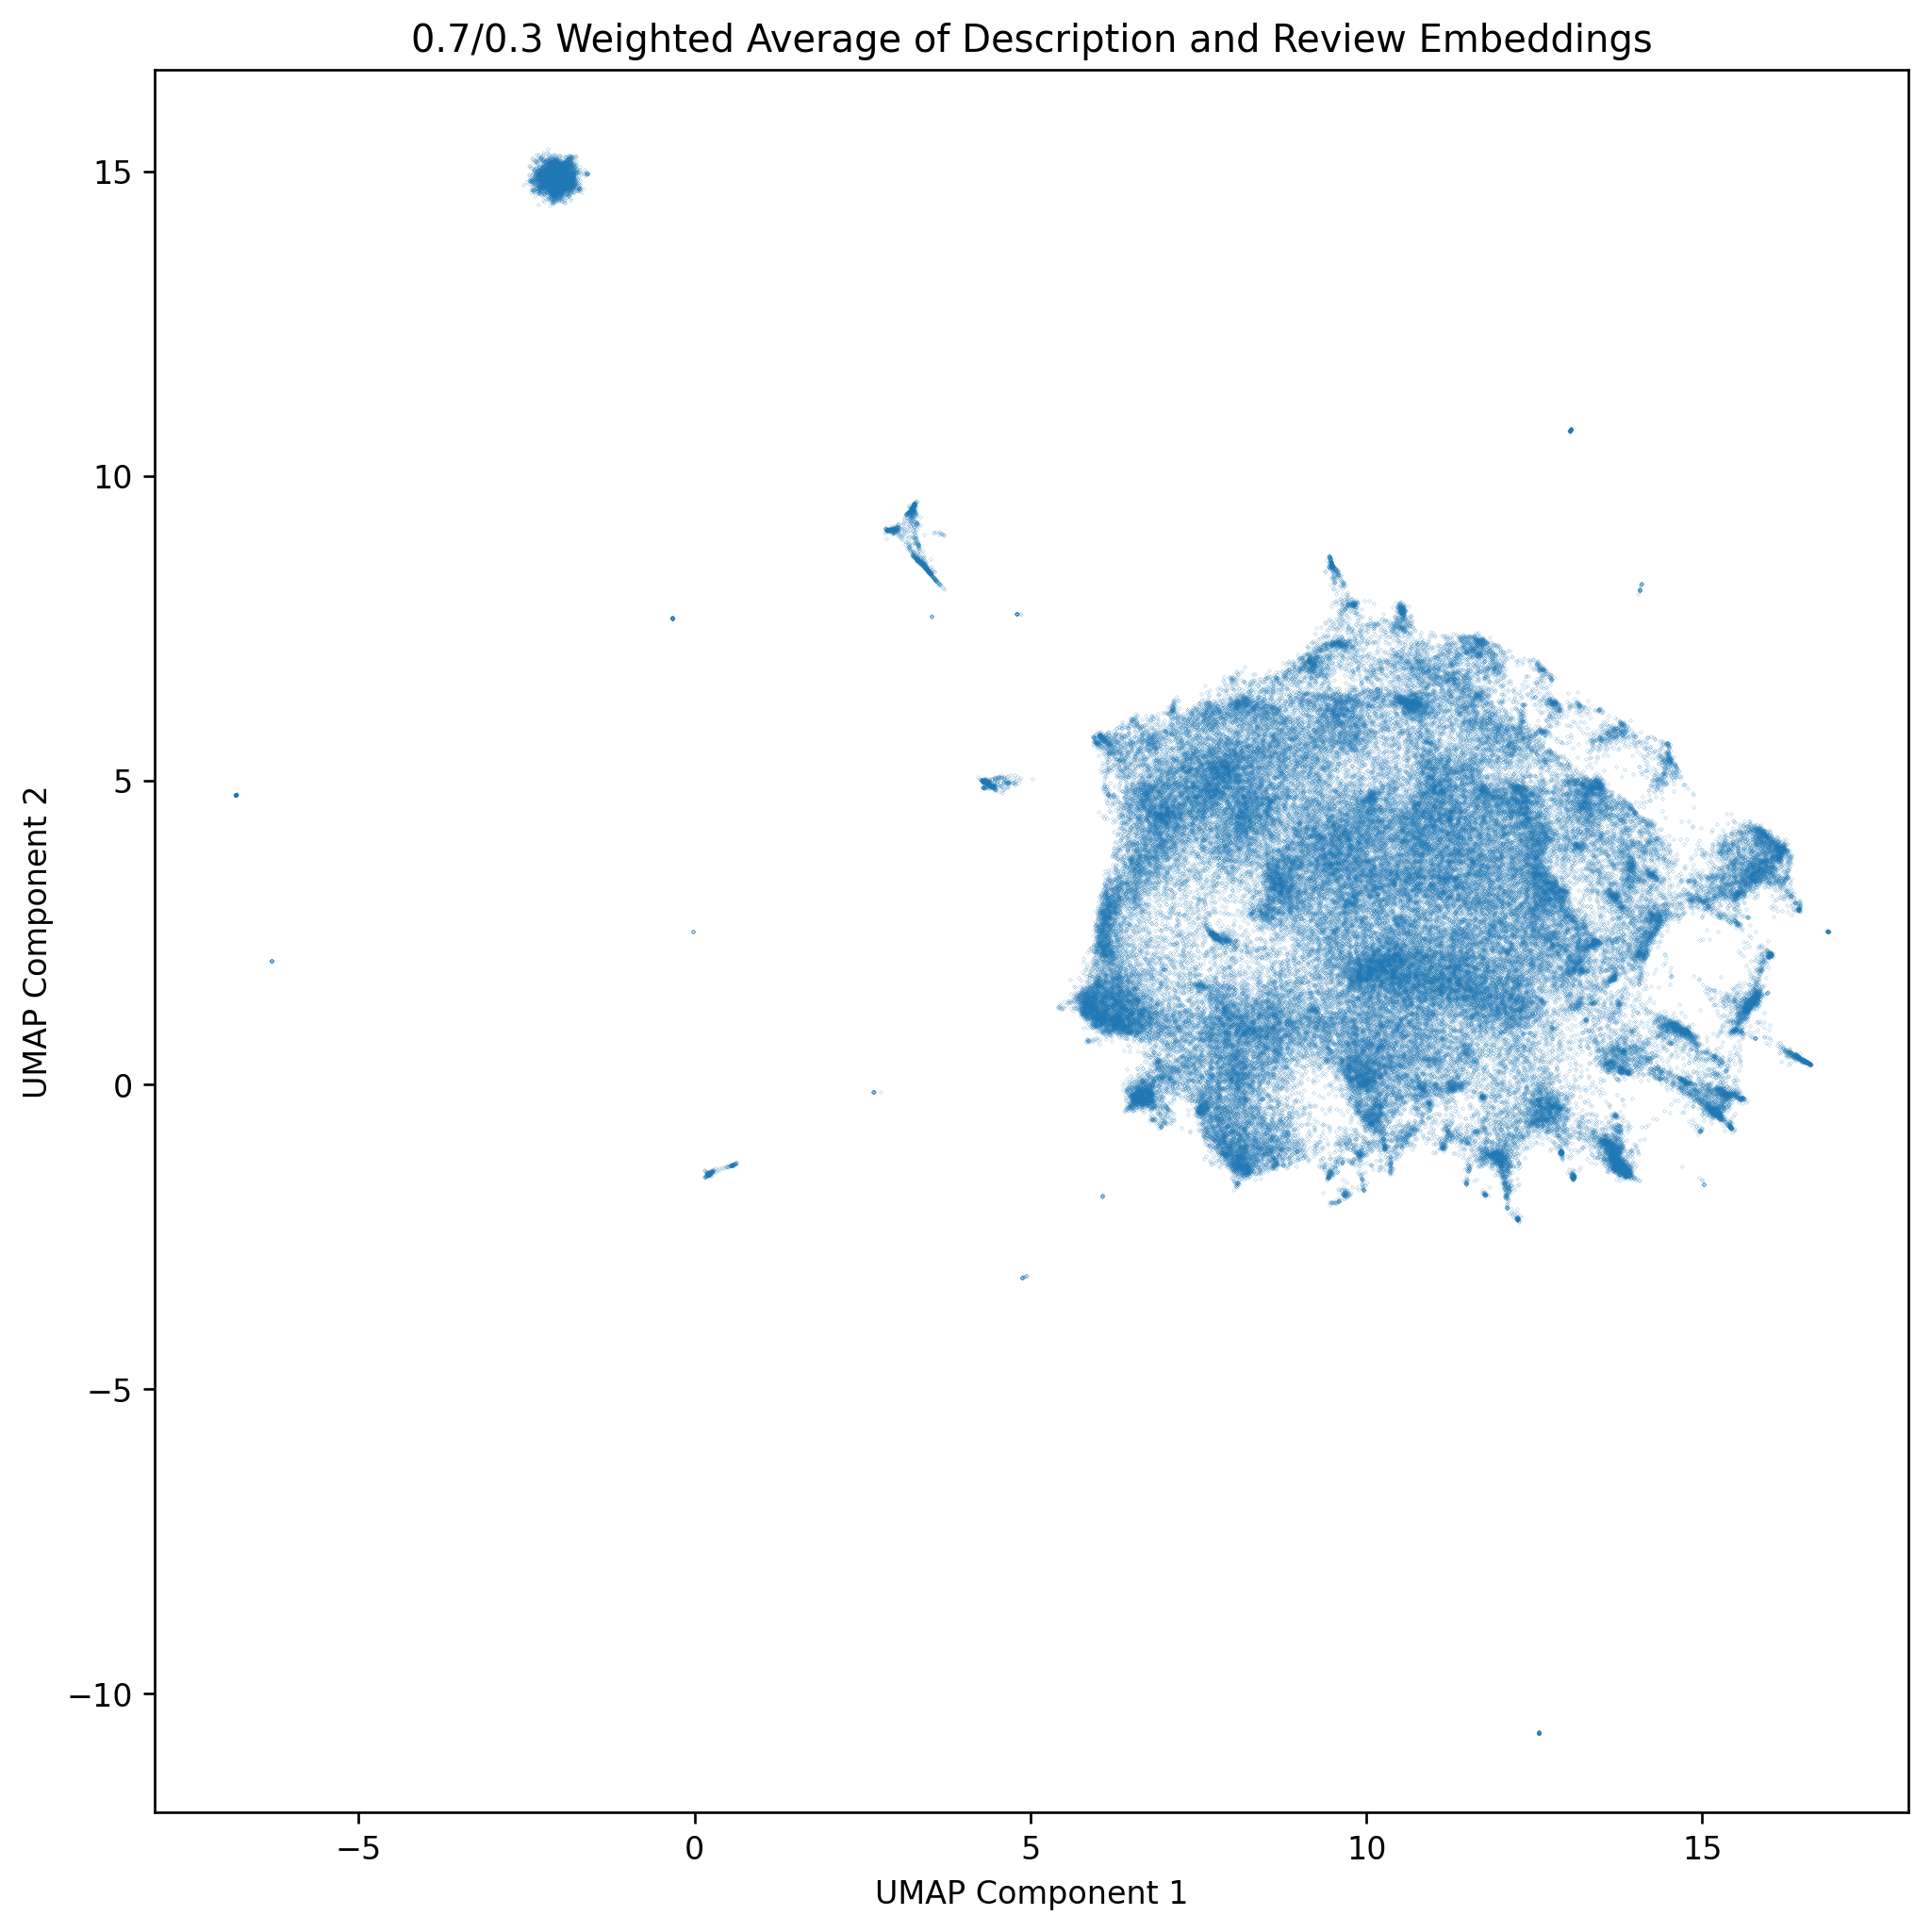

In [31]:
if 'run_plot' in locals():
  import numpy as np
  import matplotlib.pyplot as plt
  from sklearn.manifold import TSNE
  from sklearn.decomposition import PCA
  import umap


  # Step 1: Load your embeddings dataset
  # Assuming embeddings is a numpy array of shape (n_samples, 768)
  # Replace this with your actual data loading code
  #embeddings = np.load('path_to_your_embeddings.npy')


  embeddings = []
  review_weight = 0.7

  # Description embeddings
  #for appid in tqdm(get_appids_with_descriptions(), desc='Loading embeddings'):
  #  embeddings.append(get_pooled_description_embedding_for_appid(appid))

  # Review embeddings
  #for appid in tqdm(get_appids_with_reviews(), desc='Loading embeddings'):
  #  embeddings.append(get_pooled_review_embeddings_for_appid(appid))

  # Mixed embeddings
  for batch in tqdm(get_mixed_by_appid_batched(review_weight=review_weight), desc='Loading embeddings'):
    batch_appids, batch_embeddings = zip(*batch)
    embeddings.extend(batch_embeddings)

  embeddings = np.array(embeddings)

  # Step 2: Use PCA to reduce dimensionality to 50
  print("Running PCA to reduce dimensionality to 50...")
  pca = PCA(n_components=50, random_state=42)
  embeddings_pca = pca.fit_transform(embeddings)

  # Step 3: Use UMAP to reduce dimensionality to 2D
  print("Running UMAP to reduce dimensionality to 2D...")
  umap_reducer = umap.UMAP(n_components=2)
  embeddings_2d = umap_reducer.fit_transform(embeddings_pca)


  # Step 4: Plot the 2D embeddings
  plt.figure(figsize=(10, 10),dpi=240)
  plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=0.004, cmap='viridis')
  plt.title(f'{review_weight:.1f}/{1.0-review_weight:.1f} Weighted Average of Description and Review Embeddings')
  plt.xlabel('UMAP Component 1')
  plt.ylabel('UMAP Component 2')
  plt.show()

/tmp/ipykernel_1044785/3628616408.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=0.004, cmap='viridis')


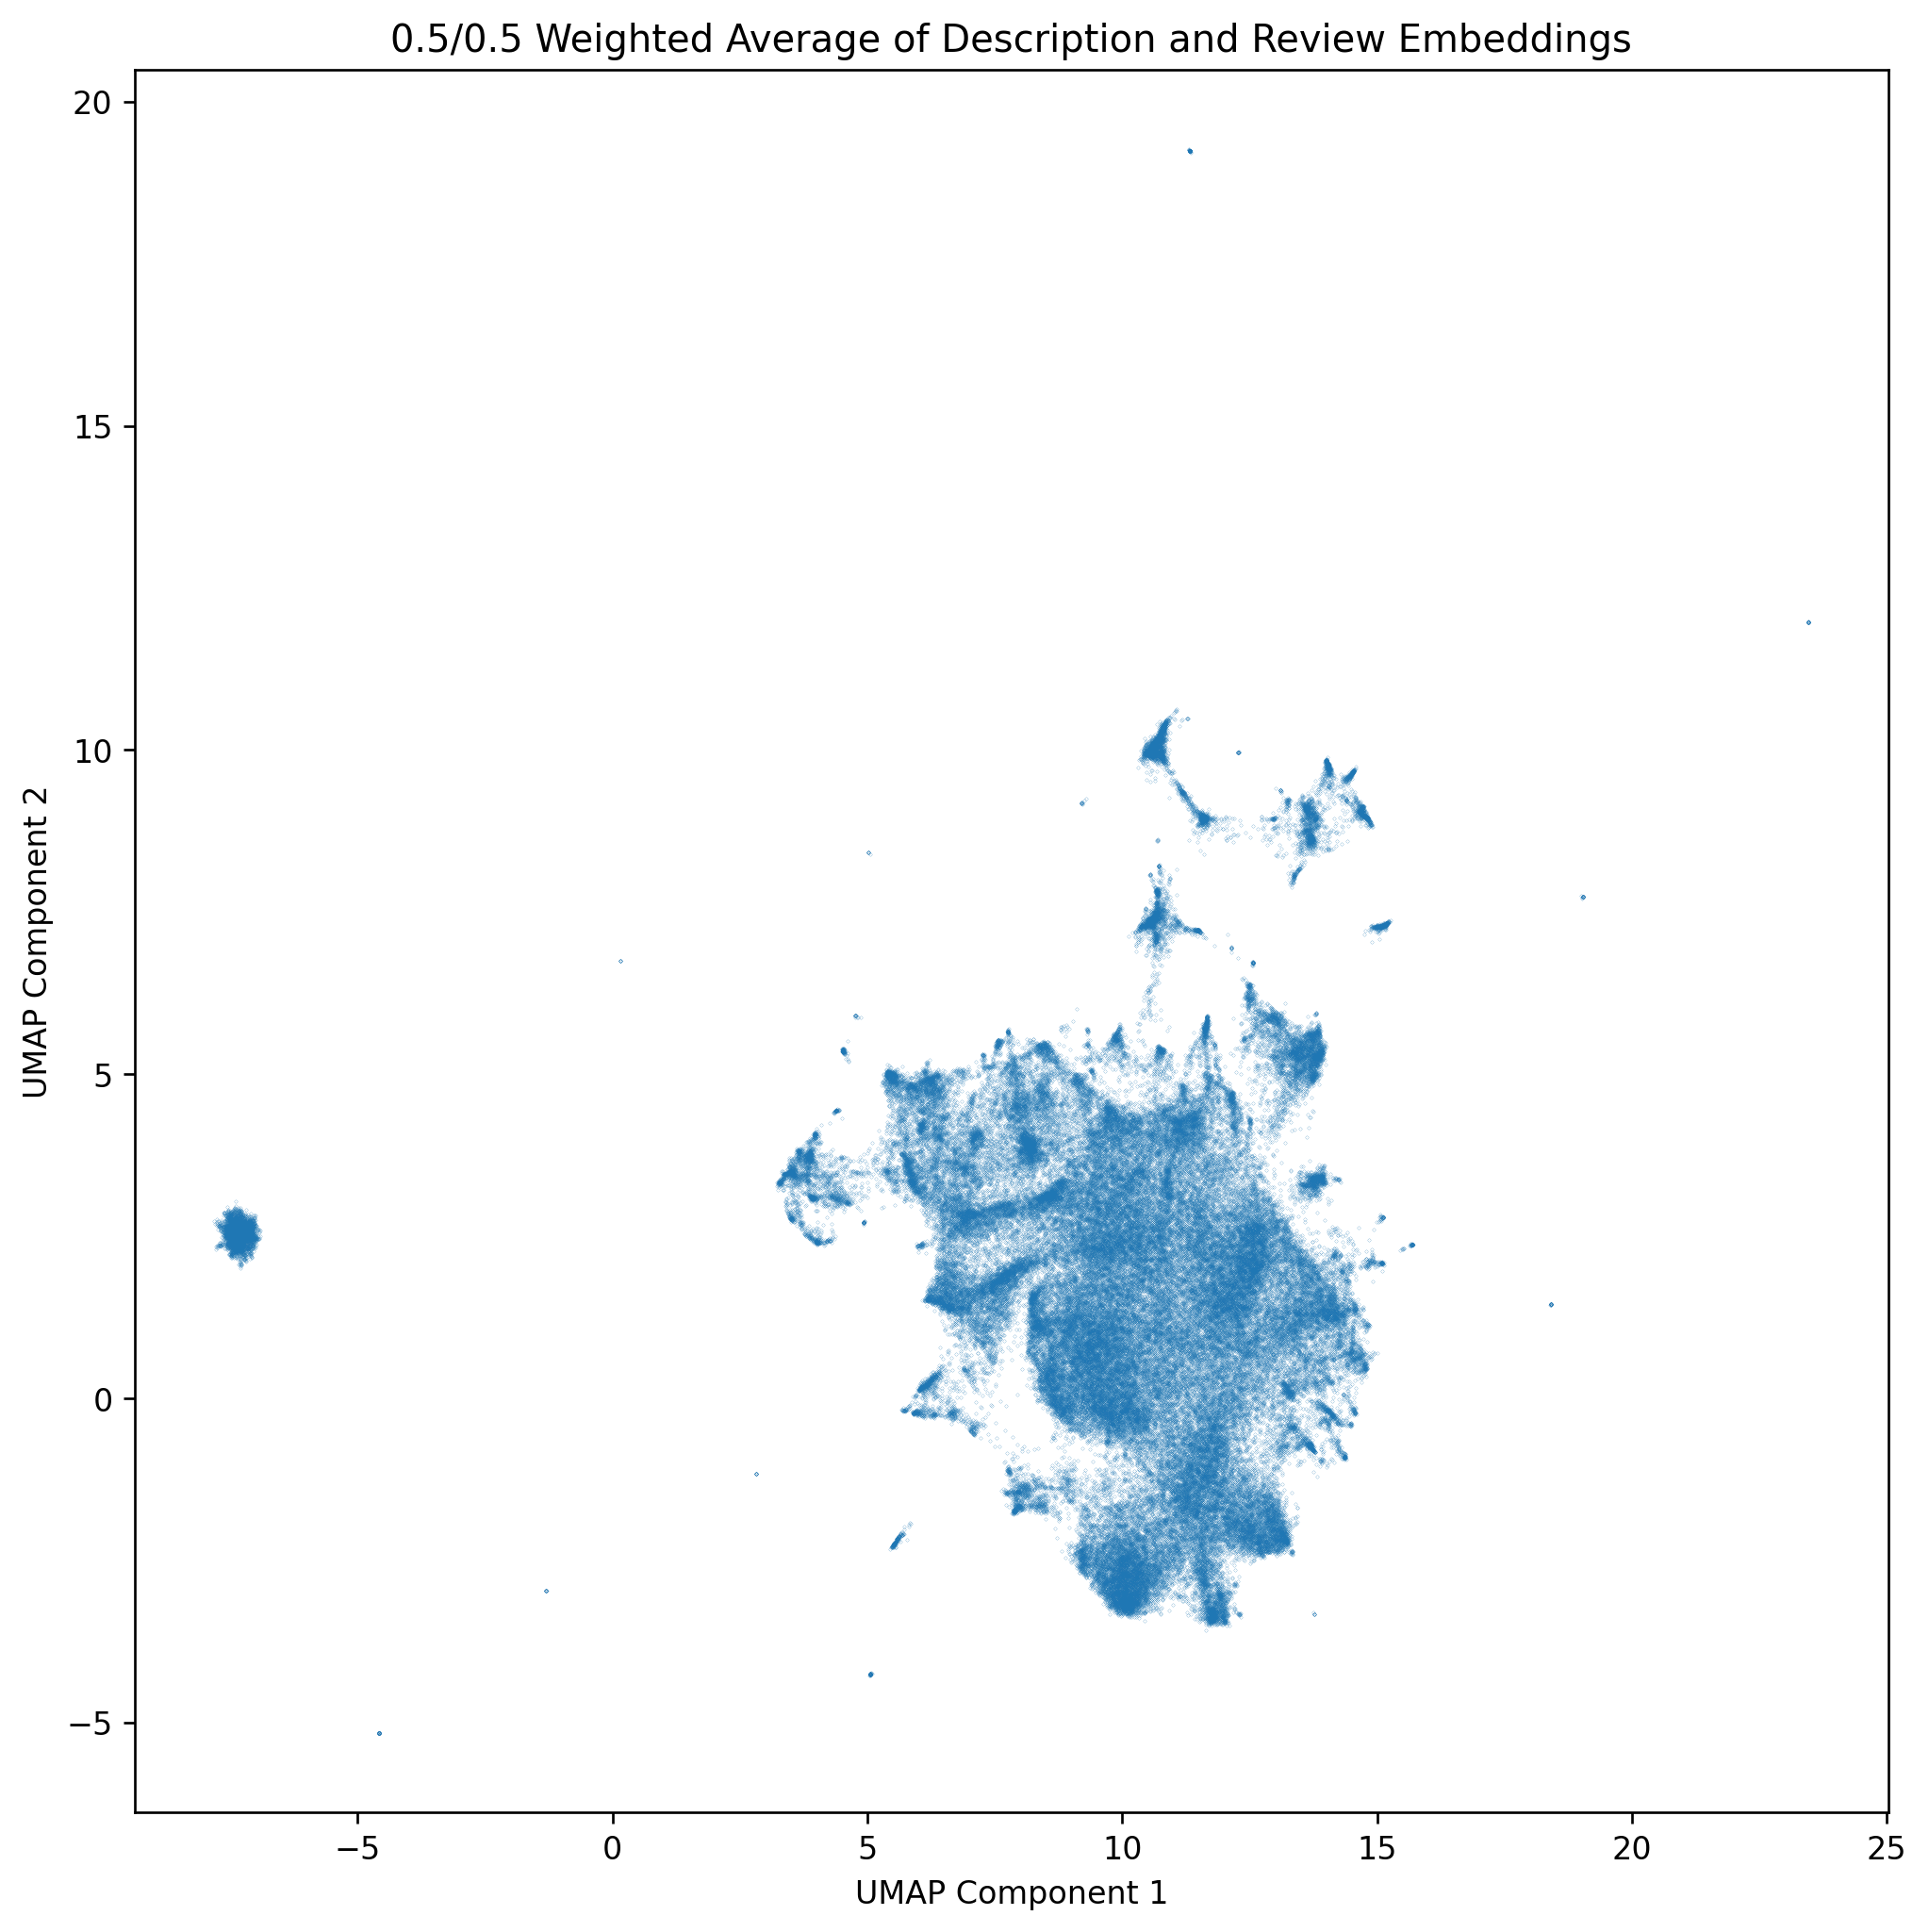

In [30]:
if 'run_plot' in locals():
  plt.figure(figsize=(10, 10),dpi=240)
  plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=0.004, cmap='viridis')
  plt.title(f'{review_weight:.1f}/{1.0-review_weight:.1f} Weighted Average of Description and Review Embeddings')
  plt.xlabel('UMAP Component 1')
  plt.ylabel('UMAP Component 2')
  plt.show()

# Recall Testing

## Description Embeddings

### `cosine` Distance

**Results Table**  

| k  | ef  | M  | recall | time to build | query time (batched) | query time (individual) |
|----|-----|----|--------|---------------|----------------------|-------------------------|
| 10 | 200 | 54 | 55-56% | N/A | N/A | N/A |
| 10 | 400 | 48 | 77%  | N/A | N/A | N/A |
| 10 | 800 | 48 | 88% | `4m15s`* (?) | N/A | N/A |
| 10 | 2000 | 32 | 93% | `2m22s` | `4s` total / `2ms` per query | `4.8ms` per query |
| 10 | 2000 | 48 | 95% | `7m53s`* | `11s`* total / `5.5ms` per query | N/A |
| 10 | 5000 | 28 | 97.7% | `4m14s` | `8.8s` total / `4.4ms` per query | `10.5ms` per query |
| 64 | 8000/2500 | 64 | 95.5% | `8m38s` | `8.2s` total | `8.2ms` per query |
| 32 | 5000/2000 | 32 | 94.1% | `5m50s` | `5.3s` total | `5.7ms` per query |

<!-- not enough queries made -->
<!--| 10 | 200 | 48 | ~56%    |-->

(?) - Seems suspect  
\* - Numbers from M1 MBP, slower than rest (which is Ryzen 7 5800X)

### `l2` Distance

**Results Table**

| k  | ef  | M  | recall | time to build | query time (batched) | query time (individual) |
|----|-----|----|--------|---------------|----------------------|-------------------------|
| 10 | 2000 | 28 | 93% | `2m15s` | `3.2s` total | `4.44ms` per query |

## Review Embeddings

### `cosine` Distance

**Results Table**  

| k  | ef  | M  | recall | time to build | query time (batched) | query time (individual) |
|----|-----|----|--------|---------------|----------------------|-------------------------|
| 10 | 2000 | 28 | 57% | `1m6s` | `1.14s` | `2.14ms` |
| 10 | 2000 | 48 | 57% | `1m10s` | `1.18s` |  |
| 10 | 10000 | 28 | 88% | `3m22s` | `7.9s` | `11.66ms` |
| 10 | 10000 | 48 | 89% | `3m26s` | `8s` | `11.9ms` |
| 10 | 15000 | 28 | 92% | `4m13s` | `10s` | `15.4ms` |
| 32 | 15000/2500 | 32 | 57% | `5m21s` | `3.7s` | `4.4ms` |
| 32 | 15000/2500 | 64 | 57% | `5m37s` | `4.3s` | `4.8ms` |
| 32 | 15000/5000 | 32 | 70% | `5m20s` | `6.3s` | `7.4ms` |
| 32 | 30000/2500 | 32 | 69% | `7m26s` | `4.9s` | `5.3ms` |

## Mixed Embeddings
> **Important Note**: Times are not directly comparable, dataset was updated to 08/2024 game list

### `cosine` Distance

**Results Table**  

| k  | ef  | ef_recall | M  | recall | time to build | query time (batched) | query time (individual) |
|----|-----|----|----|--------|---------------|----------------------|-------------------------|
| 25 | 6000 | 6000 | 48 | 89.4% | `3m25s` | `7.8s` | `9.1ms` |
| 25 | 6000 | 6000 | 64 | 89.5% | `3m31s` | `8.0s` | `9.1ms` |
| 10 | 8000 | 8000 | 28 | 93.6% | `3m42s` | `10.31s` | `10.5ms` |
| 10 | 8000 | 8000 | 32 | 94.1% | `3m47s` | `9.11s` | `10.6ms` |
| 10 | 10000 | 10000 | 28 | 95% | `4m8s` | `10.31s` | `12.3ms` |
| 10 | 15000 | 15000 | 28 | 98% | N/A | `12.58s` | `15.5ms` |
| 25 | 15000 | 200 | 64 | 45.9% | `5m29s` | `0.53s` | `0.8ms` |
| 25 | 15000 | 1000 | 64 | 76.5% | `5m29s` | `2.73s` | `3.0ms` |
| 25 | 15000 | 2000 | 64 | 84.8% | `5m29s` | `4.83s` | `5.0ms` |
| 25 | 25000 | 2000 | 64 | 88.2% | `6m51s` | `5.64s` | `5.7ms` |

--------

| k  | ef    | ef_recall | M  | recall | time to build | query time (batched) | query time (individual) |
|----|-------|-----------|----|--------|---------------|----------------------|-------------------------|
| 64 | 7000  | 7000      | 64 | 90.2%  | `3m50s`       | `8.98s`              | `10.4ms`                 |
| 64 | 10000  | 10000      | 64 | 93.5%  | `4m30s`       | `11.13s`              | `13.3ms`                 |
| 64 | 10000  | 5000      | 64 | 89.0%  | `4m33s`       | `8.27s`              | `8.8ms`                 |
| 64 | 10000  | 2500      | 64 | 82.3%  | `4m33s`       | `5.19s`              | `5.5ms`                 |
| 64 | 20000  | 2500      | 64 | 87.2%  | `6m15s`       | `6.21s`              | `6.4ms`                 |
| 64 | 30000  | 2500      | 64 | 90.0%  | `7m24s`       | `6.93s`              | `6.9ms`                 |

## Code

In [7]:
num_queries = 2000

In [8]:
dim = get_index_dimension()

indexing = 'mixed'

if indexing == 'description':
  num_elements = get_count_appids_with_description_embeddings()
elif indexing == 'review':
  num_elements = get_count_appids_with_review_embeddings()
elif indexing == 'mixed':
  #num_elements = get_count_appids_with_description_and_review_embeddings()
  num_elements = get_count_appids_with_description_or_review_embeddings()
else:
  raise Exception('Invalid indexing')

k = 32 # Number of nearest neighbors

alg = 'cosine' # can be 'l2', 'ip' or 'cosine'

# ef - the size of the dynamic list for the nearest neighbors (used during the search).
# Higher = more accurate, but slower
#ef_construction = 100000
ef_construction = num_elements
ef_recall = 2500

# M -  the number of bi-directional links created for every new element during construction.
# 12-48 is good for most cases. 
# Highly related to dimensionality of the data.
#   dim = 4 -> M = 6 - 12
#   dim = 512 -> M = 48 - 64
M = 32

In [9]:
hnsw_index = hnswlib.Index(space=alg, dim=dim)
hnsw_index.init_index(max_elements=num_elements, ef_construction=ef_construction, M=M)
hnsw_index.set_ef(ef_recall)

In [10]:

if 'bf_index' not in locals() or bf_index_initialized == False:
  bf_index = hnswlib.BFIndex(space=alg, dim=dim)
  bf_index.init_index(max_elements=num_elements)

  bf_index_initialized = False

### Build Embeddings Index

In [11]:
bar = tqdm(total=num_elements, smoothing=0.1)

if indexing == 'description':
    for batch in get_batched_description_embeddings_generator(1000):
        appids, embeddings = zip(*batch)
        embeddings = [mean_pooling(embedding) for embedding in embeddings]

        hnsw_index.add_items(embeddings, appids)

        if not bf_index_initialized:
            bf_index.add_items(embeddings, appids)
        
        bar.update(len(batch))
elif indexing == 'review':
    for batch in get_reviews_by_appid_batched(page_size=1000):
        appids, embeddings = zip(*batch)

        hnsw_index.add_items(embeddings, appids)

        if not bf_index_initialized:
            bf_index.add_items(embeddings, appids)
        
        bar.update(len(batch))
elif indexing == 'mixed':
    for batch in get_mixed_by_appid_batched(page_size=1000):
        appids, embeddings = zip(*batch)

        hnsw_index.add_items(embeddings, appids)

        if not bf_index_initialized:
            bf_index.add_items(embeddings, appids)
        
        bar.update(len(batch))

bar.close()
bf_index_initialized = True

  0%|          | 0/116618 [00:00<?, ?it/s]

### Test

In [21]:
ef_recall = 1500
hnsw_index.set_ef(ef_recall)

In [23]:

# Time batched queries (num_queries queries at a time)
query_data = np.float32(np.random.random((num_queries, dim)))

print("Querying hnsw index...", end="")
hnsw_begin = time.perf_counter()
labels_hnsw, distances_hnsw = hnsw_index.knn_query(query_data, k)
hnsw_end = time.perf_counter()
print(f"took {hnsw_end - hnsw_begin:.2f} seconds")

print("Querying brute force index...", end="")
bf_begin = time.perf_counter()
labels_bf, distances_bf = bf_index.knn_query(query_data, k)
bf_end = time.perf_counter()
print(f"(took {bf_end - bf_begin:.2f} seconds)")

correct = sum([1 for i in range(num_queries) for label in labels_hnsw[i] if label in labels_bf[i]])

print(f"recall is : {float(correct)/(k*num_queries)*100.0:.2f}%")

Querying hnsw index...took 5.47 seconds
Querying brute force index...(took 7.58 seconds)
recall is : 90.82%


In [20]:
# Time individual queries
# One timer on outer loop: 0.056638814979000016 seconds
# Timer on inner loop:     0.05581076550566649 seconds
query_data = np.float32(np.random.random((num_queries, dim)))

total_time = 0.0
bf_time = 0.0

for i in trange(num_queries):
    query = query_data[i]

    hnsw_begin = time.perf_counter()
    _ = hnsw_index.knn_query(query, k)
    hnsw_end = time.perf_counter()

    bf_begin = time.perf_counter()
    _ = bf_index.knn_query(query, k)
    bf_end = time.perf_counter()

    total_time += hnsw_end - hnsw_begin
    bf_time += bf_end - bf_begin

print(f"Average time per query: {total_time / num_queries * 1000:.1f} milliseconds")
print(f"Average time per query (brute force): {bf_time / num_queries * 1000:.1f} milliseconds")

  0%|          | 0/2000 [00:00<?, ?it/s]

KeyboardInterrupt: 